<a href="https://colab.research.google.com/github/alik604/MNIST_Brain/blob/master/BCI%202a/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for common spatial pattern (CSP) feature calculation and classification for EEG data

> Adapted from https://github.com/MultiScale-BCI/IV-2a



### Get data

In [1]:
# !pip install lightgbm scikit-plot xgboost catboost mlxtend xgboost scikit-plot pyriemann # eclf
# !git clone https://github.com/alik604/MNIST_Brain.git

!ls 'MNIST_Brain/BCI 2a/data_2a_mat'

A01E.mat  A02T.mat  A04E.mat  A05T.mat	A07E.mat  A08T.mat
A01T.mat  A03E.mat  A04T.mat  A06E.mat	A07T.mat  A09E.mat
A02E.mat  A03T.mat  A05E.mat  A06T.mat	A08E.mat  A09T.mat


In [2]:
DATA_PATH = 'MNIST_Brain/BCI 2a/data_2a_mat/'
!ls 'MNIST_Brain/BCI 2a'

 csp.py        LSTM.ipynb		     readme.md
 data_2a_mat  'main_csp as notebook.ipynb'   riemannian_multiscale.py
 eig.py        main_csp.py		    'sample code - FUBAR.txt'
 filters.py    main_riemannian.py	     testing.ipynb
 get_data.py   __pycache__


In [3]:
import time

import numpy as np
import pandas as pd 
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import *

import xgboost  # xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import lightgbm # lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# import catboost # catboost.ai/docs/concepts/python-quickstart.html
import scikitplot as skplt
from mlxtend.classifier import EnsembleVoteClassifier

# import self defined functions

import sys
sys.path.append('MNIST_Brain/BCI 2a')

from csp import generate_projection, generate_eye, extract_feature
from filters import load_filterbank
from get_data import get_data

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

# import matplotlib.pyplot as plt
# %matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Init

In [4]:
crossvalidation = False

# data_path = 'data_2a_mat/'
data_path = DATA_PATH

svm_kernel = 'linear'  # 'sigmoid'#'linear' # 'sigmoid', 'rbf', 'poly'
svm_c = 0.1  # 0.05 for linear, 20 for rbf, poly: 0.1
useCSP = True
NO_splits = 5  # number of folds in cross validation
fs = 250.  # sampling frequency
NO_channels = 22  # number of EEG channels
NO_subjects = 9
NO_csp = 24  # Total number of CSP feature per band and timewindow
bw = np.array([2, 4, 8, 16, 32])  # bandwidth of filtered signals
ftype = 'butter'  # 'fir', 'butter'
forder = 2  # 4
filter_bank = load_filterbank(bw, fs, order=forder, max_freq=40,
                                   ftype=ftype)  # get filterbank coeffs
time_windows_flt = np.array([
    [2.5, 3.5],
    [3, 4],
    [3.5, 4.5],
    [4, 5],
    [4.5, 5.5],
    [5, 6],
    [2.5, 4.5],
    [3, 5],
    [3.5, 5.5],
    [4, 6],
    [2.5, 6]]) * fs  # time windows in [s] x fs for using as a feature

time_windows = time_windows_flt.astype(int)
# restrict time windows and frequency bands
# time_windows = time_windows[10] # use only largest timewindow
# filter_bank = filter_bank[18:27] # use only 4Hz bands

NO_bands = filter_bank.shape[0]
NO_time_windows = int(time_windows.size / 2)
NO_features = NO_csp * NO_bands * NO_time_windows
global train_time
train_time = 0
train_trials = 0
global eval_time
eval_time = 0
eval_trials = 0

In [5]:
# 1. Get data
subject = 1 # [1..10]
train_data, train_label = get_data(subject, True, data_path)
eval_data, eval_label = get_data(subject, False, data_path)

# 2. Apply CSP to bands to get spatial filter
if useCSP:
    w = generate_projection(train_data, train_label, NO_csp, filter_bank, time_windows)
else:
    w = generate_eye(train_data, train_label, filter_bank, time_windows)

# 3. Extract features for training and testing
feature_mat = extract_feature(train_data, w, filter_bank, time_windows)
eval_feature_mat = extract_feature(eval_data, w, filter_bank, time_windows)

In [6]:
# 4. Train Model(s)
start_train = time.time()

clf = LinearSVC(C=svm_c, loss='hinge', random_state=1, tol=0.00001)   # 0.87
# clf = SVC(svm_c, svm_kernel, degree=10, gamma='auto', coef0=0.0, tol=0.001, cache_size=10000, max_iter=-1, decision_function_shape='ovr')  # 0.85
_ = clf.fit(feature_mat, train_label)

success_rate = clf.score(eval_feature_mat, eval_label)
print(f'Acc: {success_rate:.5f} Time taken: { time.time() - start_train:.3f}')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=1, tol=1e-05, verbose=0)

Acc: 0.86833 Time taken: 10.956


In [19]:
X_train = feature_mat.copy()
X_test = eval_feature_mat.copy()

print(f'Data is of shape {X_train.shape}')
wanted_explained_variance_ratio = 0.95
wanted_n_components = min(X_train.shape)
steps_down =  5 # wanted_n_components // 80

first_time = True

for i in range(wanted_n_components-1, 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
    break

print("We should set n_components to: ", wanted_n_components)
print(f'If we use PCA(n={wanted_n_components}), we can be left with only {100 * wanted_n_components/mim(X_train.shape):.2f}% of the original data')


pca = PCA(n_components=wanted_n_components, copy=False)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
y_train = train_label
y_test = eval_label
print(f'Data is now of shape :{X_train.shape})')

Data is of shape (273, 11352)
i = 272 with a variance ratio of 1.0
i = 267 with a variance ratio of 0.99589
i = 262 with a variance ratio of 0.99156
i = 257 with a variance ratio of 0.98706
i = 252 with a variance ratio of 0.98241
i = 247 with a variance ratio of 0.97761
i = 242 with a variance ratio of 0.97268
i = 237 with a variance ratio of 0.96763
i = 232 with a variance ratio of 0.96243
i = 227 with a variance ratio of 0.9571
i = 222 with a variance ratio of 0.95163
i = 217 with a variance ratio of 0.94347
We should set n_components to:  222


NameError: ignored

In [8]:
# Subject #1, 0.87900 for the EnsembleVoteClassifier
# Subject #1, PCA(n=222), 0.74733 for the EnsembleVoteClassifier

X_train = feature_mat
X_test = eval_feature_mat

SVM = SVC(C=1, cache_size=1000, probability=True, tol=0.00001) # DecisionTreeClassifier() # 0.85 with default C. 
RFC = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=350, random_state=42, n_jobs=-1)
# XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=500, objective='multiclass')

list_of_CLFs_names = []
list_of_CLFs = [SVM, RFC, ETC, GBM] # XGB
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)


eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

Acc: 0.85053 for the SVC
Acc: 0.87900 for the RandomForestClassifier
Acc: 0.85765 for the ExtraTreesClassifier
Acc: 0.86477 for the LGBMClassifier
Acc: 0.86121 for the EnsembleVoteClassifier


Acc: 1.00000 for the EnsembleVoteClassifier


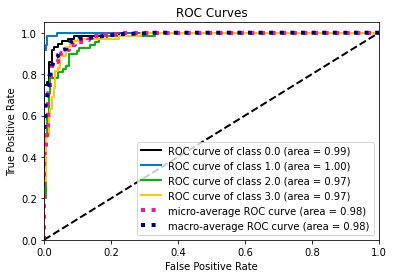

In [31]:
# X_train = feature_mat
# X_test = eval_feature_mat

# eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
# _ = eclf.fit(X_train, y_train)
pred = eclf.score(X_train, y_train)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
skplt.metrics.plot_roc(y_true=y_test, y_probas=probas)

In [10]:
feature_mat.shape
eval_feature_mat.shape

(273, 11352)

(281, 11352)

In [11]:
## Note toself consider this..

# X_train = np.reshape(train_samples,[train_samples.shape[0],1,train_samples.shape[1],train_samples.shape[2]]).astype('float32')
# y_train = np.reshape(train_labels,[train_labels.shape[0],1]).astype('float32')

# X_val = np.reshape(val_samples,[val_samples.shape[0],1,val_samples.shape[1],val_samples.shape[2]]).astype('float32') 
# y_val = np.reshape(val_labels,[val_labels.shape[0],1]).astype('float32')

In [12]:
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

seq_length = 0

X_train = feature_mat
X_test = eval_feature_mat
y_train = train_label[seq_length:]
y_test = eval_label[seq_length:]

y_train = y_train-1
y_test = y_test-1
y_train_oneHot, y_test_oneHot = to_categorical(y_train), to_categorical(y_test)

# seqLen=60
# seq_train=sequence.pad_sequences(sequences=X_train, maxlen=seq_length, padding='post', dtype='float32', truncating='post')
# seq_test=sequence.pad_sequences(sequences=X_test, maxlen=seq_length, padding='post', dtype='float32', truncating='post')

## OR...

# def build_dataset(time_series, seq_length = seq_length):
#     dataX = []
#     for i in range(0, len(time_series) - seq_length):
#         _x = time_series[i:i + seq_length]
# #         print(_x, "->", _y)
#         dataX.append(_x)
#     return np.array(dataX)

# x_train = build_dataset(X_train)
# x_test = build_dataset(X_test)

x_train = X_train
x_test = X_test

print(x_train.shape)
print(x_test.shape)

print("Reshaping..")
# N_samples, time, features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test  = np.reshape(x_test,  (x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print(x_test.shape)

print(y_train_oneHot[0])

print(y_train_oneHot.shape)
print(y_test_oneHot.shape)

(273, 11352)
(281, 11352)
Reshaping..
(273, 11352, 1)
(281, 11352, 1)
[0. 0. 0. 1.]
(273, 4)
(281, 4)


<Figure size 864x216 with 0 Axes>

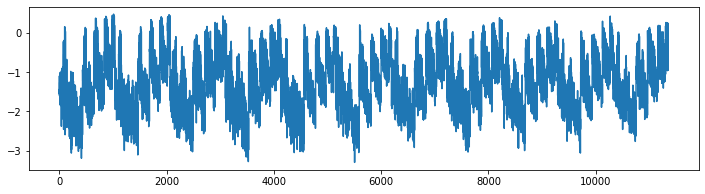

<Figure size 864x216 with 0 Axes>

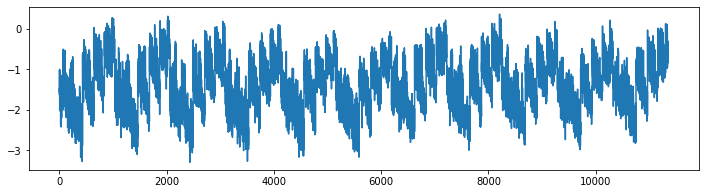

In [13]:
plt.figure(figsize=(12,3))
plt.plot(x_train[0])
plt.show()
plt.figure(figsize=(12,3))
plt.plot(x_train[80])

In [20]:
model = Sequential()
model.add(Bidirectional(LSTM(100, stateful=False, return_sequences=False))) # ,return_sequences=True is need for deep ("stacked") # stateful=False
model.add(BatchNormalization())
model.add(GaussianNoise(stddev=0.3))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))

model.add(Dense(4, activation='softmax'))

opt = tf.optimizers.RMSprop(0.002)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.summary()

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [] 
callbacks.append(ReduceLROnPlateau(monitor='loss', patience=6, factor=0.5))
callbacks.append(EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

history = model.fit(x_train, y_train_oneHot, epochs=100, batch_size=32, validation_data=(x_test, y_test_oneHot), callbacks=callbacks).history

Epoch 1/100
9/9 [==============================] - 9s 994ms/step - loss: 1.1936 - accuracy: 0.4689 - val_loss: 1.3849 - val_accuracy: 0.2491
Epoch 2/100
9/9 [==============================] - 8s 935ms/step - loss: 1.0150 - accuracy: 0.5165 - val_loss: 1.4815 - val_accuracy: 0.2491
Epoch 3/100
9/9 [==============================] - 8s 917ms/step - loss: 0.8835 - accuracy: 0.5971 - val_loss: 1.4670 - val_accuracy: 0.2491
Epoch 4/100
9/9 [==============================] - 8s 927ms/step - loss: 0.8143 - accuracy: 0.5824 - val_loss: 1.5776 - val_accuracy: 0.2491
Epoch 5/100
9/9 [==============================] - 8s 927ms/step - loss: 0.8528 - accuracy: 0.6007 - val_loss: 1.4366 - val_accuracy: 0.2491
Epoch 6/100
9/9 [==============================] - 8s 937ms/step - loss: 0.9002 - accuracy: 0.5897 - val_loss: 1.4542 - val_accuracy: 0.2527
Epoch 7/100
9/9 [==============================] - 8s 929ms/step - loss: 0.7857 - accuracy: 0.6300 - val_loss: 1.6135 - val_accuracy: 0.2491
Epoch 8/100
9

LAST: 90th epoch: 9/9 [==============================] - 4s 495ms/step - loss: 0.4764 accuracy: 0.8168 - val_loss: 0.5437 - val_accuracy: 0.7794

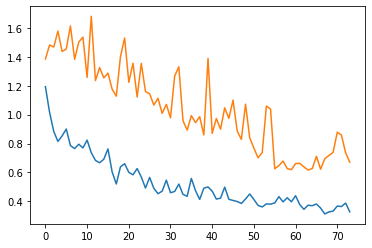

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [25]:
history = model.fit(x_train, y_train_oneHot, epochs=10, batch_size=16, validation_data=(x_test, y_test_oneHot)).history

Epoch 1/10
18/18 [==============================] - 14s 799ms/step - loss: 0.3609 - accuracy: 0.8462 - val_loss: 0.7466 - val_accuracy: 0.7295
Epoch 2/10
18/18 [==============================] - 14s 804ms/step - loss: 0.3748 - accuracy: 0.8095 - val_loss: 0.7544 - val_accuracy: 0.7367
Epoch 3/10
18/18 [==============================] - 15s 808ms/step - loss: 0.3653 - accuracy: 0.8315 - val_loss: 0.7098 - val_accuracy: 0.7687
Epoch 4/10
18/18 [==============================] - 15s 808ms/step - loss: 0.3995 - accuracy: 0.8462 - val_loss: 0.7965 - val_accuracy: 0.7224
Epoch 5/10
18/18 [==============================] - 14s 799ms/step - loss: 0.2891 - accuracy: 0.8938 - val_loss: 0.7572 - val_accuracy: 0.7438
Epoch 6/10
18/18 [==============================] - 15s 818ms/step - loss: 0.4717 - accuracy: 0.8571 - val_loss: 0.7013 - val_accuracy: 0.7580
Epoch 7/10
18/18 [==============================] - 14s 803ms/step - loss: 0.3608 - accuracy: 0.8425 - val_loss: 0.7105 - val_accuracy: 0.7651

In [17]:
# model = Sequential()
# model.add(Conv2D(128, (1,24), kernel_regularizer=regularizers.l2(0.01))) # ,return_sequences=True is need for deep ("stacked") # stateful=False
# model.add(BatchNormalization())
# model.add(GaussianNoise(stddev=0.3))

 
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(64, activation='relu'))

# model.add(Dense(4, activation='softmax'))

# opt = tf.optimizers.RMSprop(0.002)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# callbacks = [] 
# callbacks.append(ReduceLROnPlateau(patience=4, factor=0.5))
# callbacks.append(EarlyStopping(patience=7, restore_best_weights=True))

# history = model.fit(x_train, y_train_oneHot, epochs=100, batch_size=32, validation_data=(x_test, y_test_oneHot), callbacks=callbacks).history